In [1]:
# ======================== Imports ========================
import re, unicodedata
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

PAD_IDX = 0

# Hyperparameter tuning imports
try:
    import keras_tuner as kt
    KERAS_TUNER_AVAILABLE = True
except ImportError:
    KERAS_TUNER_AVAILABLE = False
    print("Keras Tuner not available. Install with: pip install keras-tuner")

# ======================== Config ========================
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

# ======================== Preprocessing ========================
def custom_preprocess(text, language):
    text = unicodedata.normalize('NFKC', text)
    
    if language == 'de':
        translation_map = str.maketrans({
            "ä": "ae", "ö": "oe", "ü": "ue", 
            "Ä": "Ae", "Ö": "Oe", "Ü": "Ue", "ß": "ss"
        })
        text = text.translate(translation_map)

    text = re.sub(r"[^a-zA-Z0-9.,!?\"'\-:;() ]", " ", text)
    text = text.replace("'", "'").replace(""", "\"").replace(""", "\"")
    text = re.sub(r"([.,!?;:\-()])", r" \1 ", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    return f"<start> {text} <end>"

class VocabularyBuilder:
    def __init__(self, texts, min_freq=0):
        from collections import Counter
        self.word_counter = Counter(word for text in texts for word in text.split())
        self.special_tokens = ['<pad>', '<unk>', '<start>', '<end>']
        self.vocab = self.special_tokens + [
            word for word, freq in self.word_counter.items() 
            if freq >= min_freq and word not in self.special_tokens
        ]
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

        # Alias for compatibility
        self.token_to_idx = self.word2idx
        self.idx_to_token = self.idx2word

    def __len__(self):
        return len(self.vocab)
    
    def __getitem__(self, word):
        return self.word2idx.get(word, self.word2idx['<unk>'])
    
    def get_word(self, idx):
        return self.idx2word.get(idx, '<unk>')

    # Add get_itos method for compatibility
    def get_itos(self):
        return [self.idx2word[i] for i in range(len(self.idx2word))]

    # Add decode method here:
    def decode(self, indices, skip_special=True):
        """
        Convert a list or array of indices to tokens (words).
        If skip_special=True, skip special tokens.
        """
        special_tokens_set = set(self.special_tokens) if skip_special else set()
        tokens = []
        for idx in indices:
            word = self.idx2word.get(idx, '<unk>')
            if skip_special and word in special_tokens_set:
                continue
            tokens.append(word)
        return tokens

def tokenize_and_pad_tf(texts, vocab, max_len=None):
    sequences = [[vocab[word] for word in text.split()] for text in texts]
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)
    
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', 
                          truncating='post', value=vocab['<pad>'])
    return padded, max_len

# ======================== Attention Mechanism ========================
class BahdanauAttention(layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

# ======================== Encoder ========================
class Encoder(layers.Layer):
    def __init__(self, vocab_size, embedding_units, lstm_units, **kwargs):
        super().__init__(**kwargs)
        self.lstm_units = lstm_units
        self.embedding = layers.Embedding(vocab_size, embedding_units)
        self.lstm = layers.Bidirectional(
            layers.LSTM(lstm_units, return_sequences=True, return_state=True)
        )

    def call(self, x, training=None):
        x = self.embedding(x)
        outputs, fh, fc, bh, bc = self.lstm(x, training=training)
        state_h = layers.Concatenate()([fh, bh])
        state_c = layers.Concatenate()([fc, bc])
        return outputs, state_h, state_c

# ======================== Decoder ========================
class Decoder(layers.Layer):
    def __init__(self, vocab_size, embedding_units, lstm_units, attention_units, **kwargs):
        super().__init__(**kwargs)
        self.lstm_units = lstm_units
        self.embedding = layers.Embedding(vocab_size, embedding_units)
        self.lstm = layers.LSTM(lstm_units * 2, return_sequences=True, return_state=True)
        self.attention = BahdanauAttention(attention_units)
        self.fc = layers.Dense(vocab_size)

    def call(self, x, enc_output, hidden, training=None):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state_h, state_c = self.lstm(x, training=training)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state_h, state_c, attention_weights

# ======================== Seq2Seq Model ========================
class Seq2Seq(Model):
    def __init__(self, src_vocab_size, tgt_vocab_size, embedding_units, 
                 lstm_units, attention_units, **kwargs):
        super().__init__(**kwargs)
        self.encoder = Encoder(src_vocab_size, embedding_units, lstm_units)
        self.decoder = Decoder(tgt_vocab_size, embedding_units, lstm_units, attention_units)

    def call(self, inputs, training=None):
        enc_input, dec_input = inputs
        enc_output, enc_h, enc_c = self.encoder(enc_input, training=training)
        
        dec_h, dec_c = enc_h, enc_c
        predictions = []
        
        for t in range(dec_input.shape[1]):
            dec_x = dec_input[:, t:t+1]
            pred, dec_h, dec_c, _ = self.decoder(dec_x, enc_output, dec_h, training=training)
            predictions.append(pred)
        
        return tf.stack(predictions, axis=1)

    def translate(self, src_seq, src_vocab, tgt_vocab, max_len=1000):
        """Translate a single tokenized & padded source sequence (batch size = 1)."""
        PAD_IDX = src_vocab['<pad>']
        START_IDX = tgt_vocab['<start>']
        END_IDX = tgt_vocab['<end>']

        # Encode
        enc_output, enc_h, enc_c = self.encoder(src_seq, training=False)

        dec_input = tf.constant([[START_IDX]], dtype=tf.int32)
        dec_h, dec_c = enc_h, enc_c

        result_tokens = []

        for _ in range(max_len):
            logits, dec_h, dec_c, _ = self.decoder(dec_input, enc_output, dec_h, training=False)
            predicted_id = tf.argmax(logits, axis=-1).numpy()[0]

            if predicted_id == END_IDX:
                break

            result_tokens.append(predicted_id)
            dec_input = tf.constant([[predicted_id]], dtype=tf.int32)

        return result_tokens

# ======================== Training Functions ========================
def create_model(src_vocab_size, tgt_vocab_size, embedding_units=128, 
                lstm_units=128, attention_units=128, learning_rate=0.001):
    model = Seq2Seq(src_vocab_size, tgt_vocab_size, embedding_units, 
                   lstm_units, attention_units)
    
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    return model

def train_model(model, x_enc_train, x_dec_train, y_train, 
               x_enc_val, x_dec_val, y_val, epochs, batch_size=8):
    
    history = model.fit(
        [x_enc_train, x_dec_train], y_train,
        validation_data=([x_enc_val, x_dec_val], y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    return history

if KERAS_TUNER_AVAILABLE:
    class Seq2SeqHyperModel(kt.HyperModel):
        def __init__(self, src_vocab_size, tgt_vocab_size):
            self.src_vocab_size = src_vocab_size
            self.tgt_vocab_size = tgt_vocab_size
        
        def build(self, hp):
            embedding_units = hp.Int('embedding_units', 128, 512, step=64)
            lstm_units = hp.Int('lstm_units', 256, 1024, step=128)
            attention_units = hp.Int('attention_units', 256, 1024, step=128)
            learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
            
            model = create_model(self.src_vocab_size, self.tgt_vocab_size,
                               embedding_units, lstm_units, attention_units, learning_rate)
            return model

def load_and_process_data(num_samples):
    # Load dataset
    dataset = load_dataset("wmt/wmt14", "de-en", split=f'train[:{num_samples}]')
    print(f"Loaded {len(dataset)} samples")
    
    # Preprocess texts
    src_texts = [custom_preprocess(x['translation']['de'], 'de') for x in dataset]
    tgt_texts = [custom_preprocess(x['translation']['en'], 'en') for x in dataset]
    
    # Build vocabularies
    src_vocab = VocabularyBuilder(src_texts)
    tgt_vocab = VocabularyBuilder(tgt_texts)
    
    print(f"Source vocab size: {len(src_vocab)}")
    print(f"Target vocab size: {len(tgt_vocab)}")
    
    # Tokenize and pad
    src_tensor, src_max_len = tokenize_and_pad_tf(src_texts, src_vocab)
    tgt_tensor, tgt_max_len = tokenize_and_pad_tf(tgt_texts, tgt_vocab)
    
    # Prepare decoder input/target
    decoder_input = tgt_tensor[1:, :-1]
    decoder_target = tgt_tensor[1:, :-1]
    
    PAD_IDX = 0  # Define PAD_IDX

    # Train/validation split
    train_idx = list(range(len(src_tensor)))  # Keep 100% of the data for training

    import random

    # Select 20% of training data for validation/test
    val_idx = random.sample(train_idx, int(len(train_idx) * 0.2))

    x_enc_train = src_tensor[train_idx]
    x_dec_train = decoder_input[train_idx]
    y_train = decoder_target[train_idx]

    x_enc_val = src_tensor[val_idx]
    x_dec_val = decoder_input[val_idx]
    y_val = decoder_target[val_idx]

    return (x_enc_train, x_dec_train, y_train, x_enc_val, x_dec_val, y_val, 
        src_vocab, tgt_vocab)

def verify_preprocessing_tf(src_tensor, tgt_tensor, src_vocab, tgt_vocab, num_samples=3):
    print("Verifying TensorFlow preprocessing...")
    PAD_IDX = 0  # Define PAD_IDX
    
    for i in range(min(num_samples, len(src_tensor))):
        print(f"\nSample {i+1}:")
        
        # Decode source sequence
        src_decoded = [src_vocab.get_word(idx) for idx in src_tensor[i] if idx != PAD_IDX]
        tgt_decoded = [tgt_vocab.get_word(idx) for idx in tgt_tensor[i] if idx != PAD_IDX]

        print(f"Source decoded: {' '.join(src_decoded)}")
        print(f"Target decoded: {' '.join(tgt_decoded)}")

        # Validate special tokens
        if "<start>" not in src_decoded or "<end>" not in src_decoded:
            print("WARNING: Source missing special tokens!")
        if "<start>" not in tgt_decoded or "<end>" not in tgt_decoded:
            print("WARNING: Target missing special tokens!")

# Main execution
if __name__ == "__main__":
    # Load and process data
    data = load_and_process_data(num_samples=2000)
    x_enc_train, x_dec_train, y_train, x_enc_val, x_dec_val, y_val, src_vocab, tgt_vocab = data
    
    verify_preprocessing_tf(x_enc_train, y_train, src_vocab, tgt_vocab)

    print(f"\nTraining shapes:")
    print(f"Encoder input: {x_enc_train.shape}")
    print(f"Decoder input: {x_dec_train.shape}")
    print(f"Decoder target: {y_train.shape}")

    # Option 1: Basic training
    print("\n=== Basic Training ===")
    model = create_model(len(src_vocab), len(tgt_vocab))
    history = train_model(model, x_enc_train, x_dec_train, y_train,
                         x_enc_val, x_dec_val, y_val, epochs=20)

    
    """
    # Option 2: Keras Tuner
    if KERAS_TUNER_AVAILABLE:
        print("\n=== Keras Tuner Hyperparameter Tuning ===")
        hypermodel = Seq2SeqHyperModel(len(src_vocab), len(tgt_vocab))
        tuner = kt.RandomSearch(
            hypermodel,
            objective='val_loss',
            max_trials=10,
            directory='seq2seq_tuning',
            project_name='seq2seq_bilstm'
        )
        
        tuner.search([x_enc_train, x_dec_train], y_train,
                    validation_data=([x_enc_val, x_dec_val], y_val),
                    epochs=3, batch_size=32)
        
        best_model = tuner.get_best_models(num_models=1)[0]
        print("Best hyperparameters:", tuner.get_best_hyperparameters()[0].values)
    """

2025-05-25 11:41:39.660334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748148099.709310  307040 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748148099.721278  307040 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-25 11:41:39.835619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loaded 2000 samples
Source vocab size: 7690
Target vocab size: 5439
Verifying TensorFlow preprocessing...

Sample 1:
Source decoded: <start> Wiederaufnahme der Sitzungsperiode <end>
Target decoded: <start> Resumption of the session <end>

Sample 2:
Source decoded: <start> Ich erklaere die am Freitag , dem 17 . Dezember unterbrochene Sitzungsperiode des Europaeischen Parlaments fuer wiederaufgenommen , wuensche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe , dass Sie schoene Ferien hatten . <end>
Target decoded: <start> I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999 , and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period . <end>

Sample 3:
Source decoded: <start> Wie Sie feststellen konnten , ist der gefuerchtete "Millenium - Bug " nicht eingetreten . Doch sind Buerger

I0000 00:00:1748148120.999451  307040 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
W0000 00:00:1748148156.663426  307294 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/ardi/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/ardi/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/ardi/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloMo

250/250 ━━━━━━━━━━━━━━━━━━━━ 332s 712ms/step - accuracy: 0.7678 - loss: 3.7870 - val_accuracy: 0.7753 - val_loss: 1.3116
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 560ms/step - accuracy: 0.7993 - loss: 1.2066 - val_accuracy: 0.8318 - val_loss: 1.0985
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 561ms/step - accuracy: 0.8466 - loss: 1.0088 - val_accuracy: 0.8571 - val_loss: 0.9424
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 145s 581ms/step - accuracy: 0.8678 - loss: 0.8908 - val_accuracy: 0.8781 - val_loss: 0.8366
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 154s 614ms/step - accuracy: 0.8832 - loss: 0.7993 - val_accuracy: 0.8920 - val_loss: 0.7527
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 151s 605ms/step - accuracy: 0.9009 - loss: 0.7080 - val_accuracy: 0.9072 - val_loss: 0.6774
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 163s 650ms/step - accuracy: 0.9116 - loss: 0.6519 - val_accuracy: 0.9184 - val_loss: 0.6097
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 156s 623ms/step - accuracy: 0.9216 - loss: 0.59

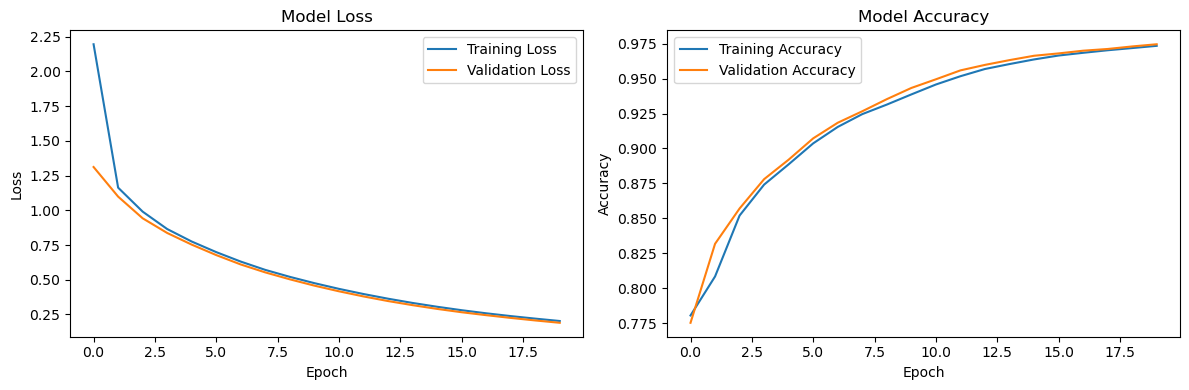

In [2]:
# ======================== Utility Functions ========================
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


2025-05-25 12:39:13.968243: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1279252800 exceeds 10% of free system memory.


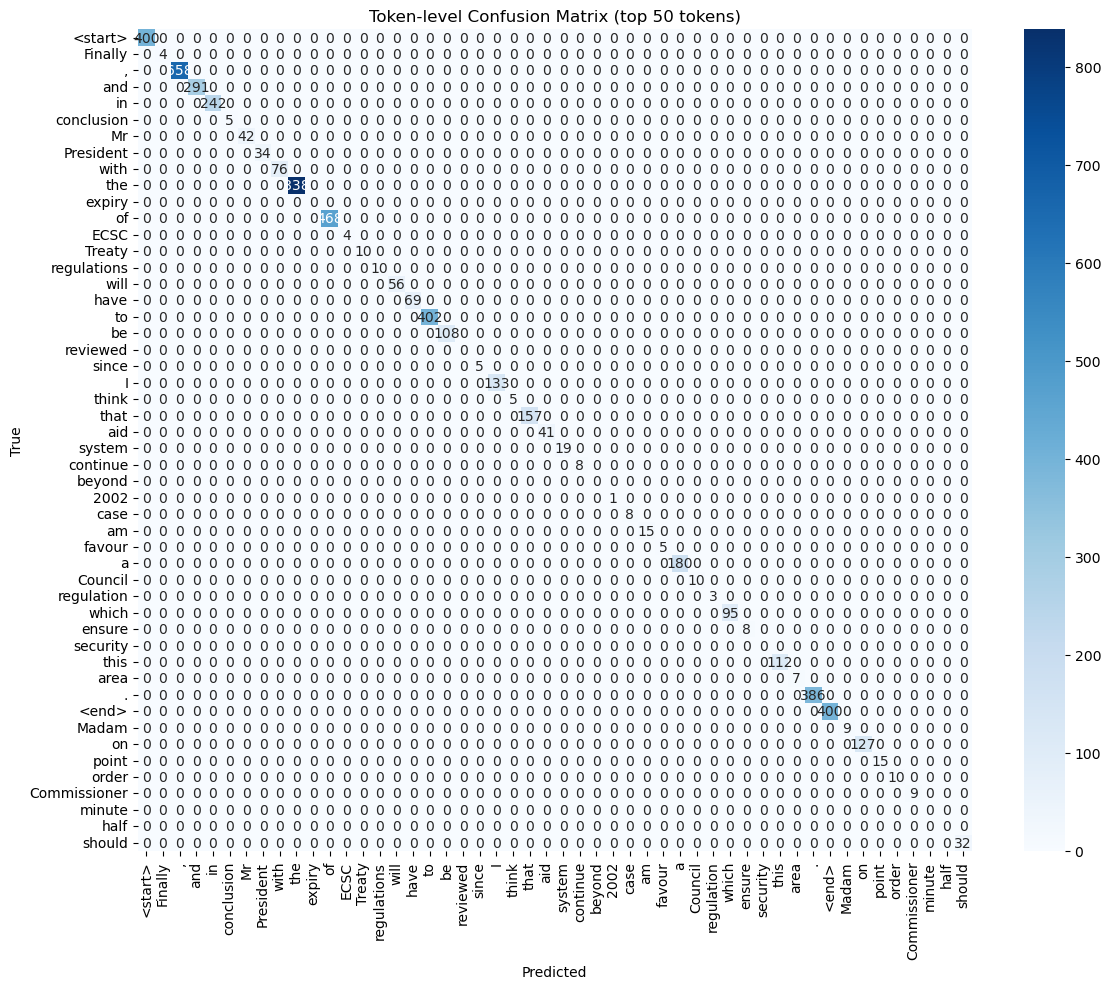

Token-level Classification Report:
              precision    recall  f1-score   support

     <start>       1.00      1.00      1.00       400
     Finally       1.00      1.00      1.00         4
           ,       1.00      1.00      1.00       658
         and       1.00      1.00      1.00       291
          in       1.00      1.00      1.00       242
  conclusion       1.00      1.00      1.00         5
          Mr       1.00      1.00      1.00        42
   President       1.00      1.00      1.00        34
        with       1.00      1.00      1.00        76
         the       0.83      1.00      0.91       838
      expiry       0.00      0.00      0.00         1
          of       1.00      1.00      1.00       468
        ECSC       1.00      1.00      1.00         4
      Treaty       1.00      1.00      1.00        10
 regulations       1.00      1.00      1.00        10
        will       1.00      1.00      1.00        56
        have       1.00      1.00      1.00   

In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_token_level(model, x_enc, x_dec, y_true, tgt_vocab, max_tokens):
    """
    Token-level evaluation comparing predicted tokens to ground truth.
    Shows confusion matrix and classification report.
    
    Args:
        model: Trained Seq2Seq model.
        x_enc: Encoder input sequences.
        x_dec: Decoder input sequences.
        y_true: True decoder target sequences.
        tgt_vocab: Target VocabularyBuilder instance.
        max_tokens: Maximum number of tokens to display in the confusion matrix.
    """
    PAD_IDX = tgt_vocab['<pad>']

    # Predict logits from the model
    y_pred_logits = model.predict([x_enc, x_dec], batch_size=1, verbose=0)
    y_pred = np.argmax(y_pred_logits, axis=-1)

    # Flatten all predictions and targets
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Filter out padding
    valid_mask = y_true_flat != PAD_IDX
    y_true_filtered = y_true_flat[valid_mask]
    y_pred_filtered = y_pred_flat[valid_mask]

    # Convert index to tokens
    idx2word = tgt_vocab.get_itos()
    y_true_tokens = [idx2word[idx] for idx in y_true_filtered]
    y_pred_tokens = [idx2word[idx] for idx in y_pred_filtered]

    # Build the confusion matrix
    labels = list(dict.fromkeys(y_true_tokens + y_pred_tokens))[:max_tokens]
    cm = confusion_matrix(y_true_tokens, y_pred_tokens, labels=labels)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
                annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Token-level Confusion Matrix (top {max_tokens} tokens)')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("Token-level Classification Report:")
    print(classification_report(y_true_tokens, y_pred_tokens, labels=labels, zero_division=0))


# Evaluate on validation set
evaluate_token_level(model, x_enc_val, x_dec_val, y_val, tgt_vocab, max_tokens=50)

400/400 ━━━━━━━━━━━━━━━━━━━━ 111s 277ms/step


2025-05-25 12:41:21.466889: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1279252800 exceeds 10% of free system memory.


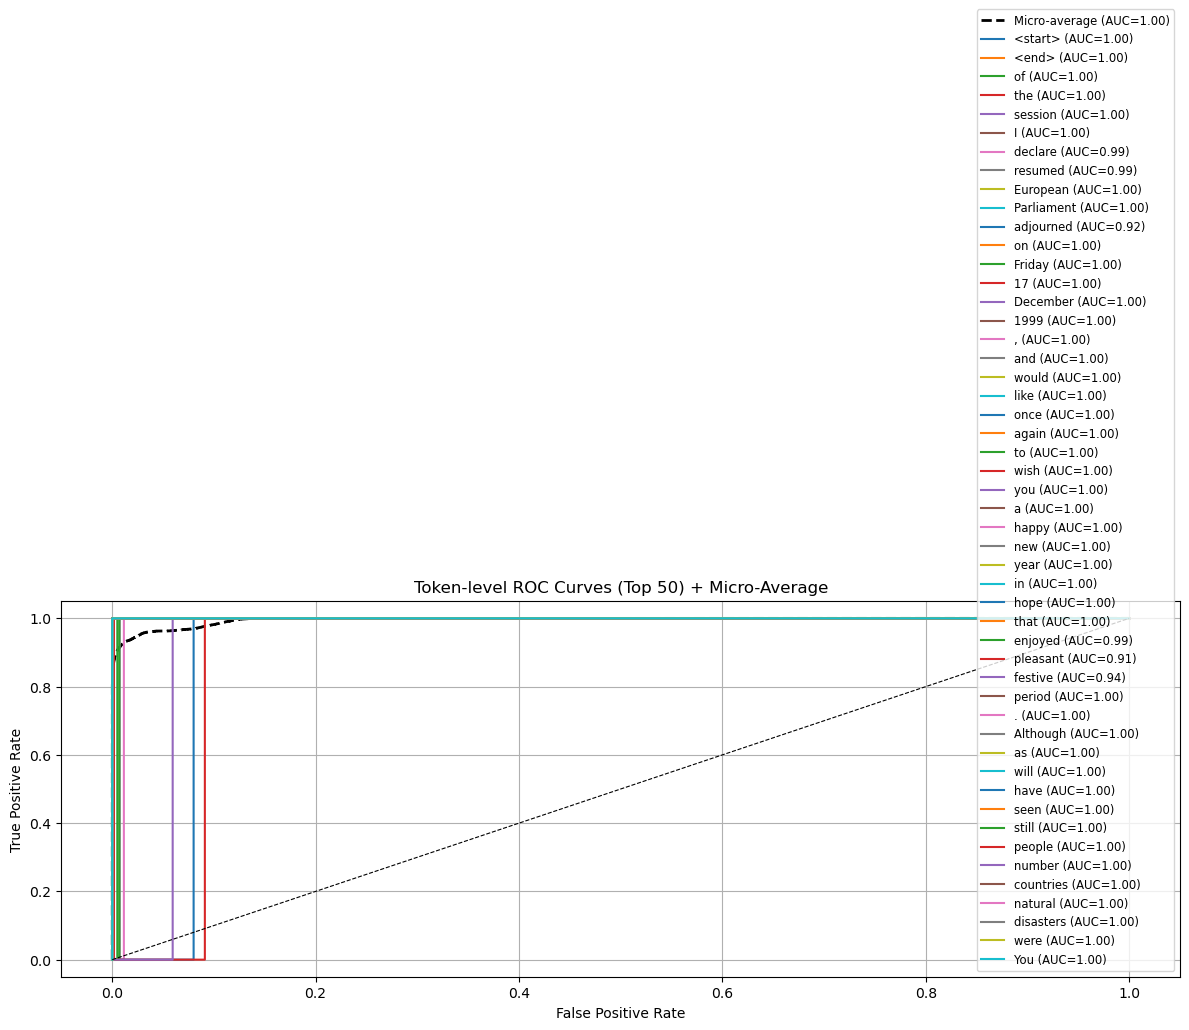

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_token_roc_auc(model, x_enc, x_dec, y_true, tgt_vocab, max_tokens):
    """
    Plot ROC-AUC curves for each token class (one-vs-rest), with micro-average.

    Parameters:
        model: Trained Seq2Seq model.
        x_enc: Encoder input (padded).
        x_dec: Decoder input (padded).
        y_true: Decoder target output (padded).
        tgt_vocab: Target vocabulary builder.
        max_tokens: Max number of token classes to plot.
    """
    PAD_IDX = tgt_vocab['<pad>']
    vocab_size = len(tgt_vocab)

    # Predict probabilities
    y_pred_logits = model.predict([x_enc, x_dec], batch_size=1)

    # Flatten to (samples*seq_len, vocab_size)
    y_pred_flat = y_pred_logits.reshape(-1, vocab_size)
    y_true_flat = y_true.flatten()

    # Remove pad tokens
    mask = y_true_flat != PAD_IDX
    y_true_filtered = y_true_flat[mask]
    y_pred_filtered = y_pred_flat[mask]

    # Binarize true labels
    y_true_bin = label_binarize(y_true_filtered, classes=list(range(vocab_size)))

    # Compute micro-average
    fpr_micro, tpr_micro, _ = roc_curve(
        y_true_bin.ravel(), y_pred_filtered.ravel()
    )
    auc_micro = roc_auc_score(y_true_bin, y_pred_filtered, average='micro')

    # Plot
    plt.figure(figsize=(12, 8))
    plt.plot(fpr_micro, tpr_micro, color='black', linestyle='--',
             label=f'Micro-average (AUC={auc_micro:.2f})', linewidth=2)

    # Per-class ROC curves
    token_scores = {}
    token_count = 0
    for token_idx in range(vocab_size):
        if np.sum(y_true_bin[:, token_idx]) == 0:
            continue  # skip unused token

        try:
            fpr, tpr, _ = roc_curve(
                y_true_bin[:, token_idx], y_pred_filtered[:, token_idx]
            )
            auc = roc_auc_score(
                y_true_bin[:, token_idx], y_pred_filtered[:, token_idx]
            )
            token_name = tgt_vocab.get_word(token_idx)
            token_scores[token_name] = auc

            plt.plot(fpr, tpr, label=f'{token_name} (AUC={auc:.2f})')
            token_count += 1

            if token_count >= max_tokens:
                break
        except ValueError:
            continue  # Skip unstable class

    plt.plot([0, 1], [0, 1], 'k--', lw=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Token-level ROC Curves (Top {token_count}) + Micro-Average')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return token_scores, auc_micro

token_auc_scores, auc_micro = plot_token_roc_auc(
    model, x_enc_val, x_dec_val, y_val, tgt_vocab, max_tokens=50
)

In [5]:
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_random_bleu_samples(model, x_enc, x_dec, y_true, 
                                 src_vocab, tgt_vocab, 
                                 max_samples, tokenizer=None):
    """
    Translate random samples and compute BLEU score for each.

    Parameters:
        model: Trained Seq2Seq model.
        x_enc, x_dec: Encoder and decoder inputs (padded).
        y_true: True target outputs (padded).
        src_vocab: Source vocabulary.
        tgt_vocab: Target vocabulary.
        max_samples: Number of random samples to evaluate.
        tokenizer: Optional tokenizer for detokenizing inputs.

    Returns:
        List of (source, reference, prediction, BLEU score) tuples.
    """
    idxs = random.sample(range(len(x_enc)), min(max_samples, len(x_enc)))
    smooth_fn = SmoothingFunction().method4
    results = []

    for i in idxs:
        # Prepare input
        enc_input = x_enc[i:i+1]
        dec_input = x_dec[i:i+1]
        y_true_seq = y_true[i]

        # Predict
        pred_probs = model.predict([enc_input, dec_input])
        pred_ids = pred_probs.argmax(axis=-1)[0]  # shape: (seq_len,)

        # Convert to tokens
        true_tokens = tgt_vocab.decode(y_true_seq, skip_special=True)
        pred_tokens = tgt_vocab.decode(pred_ids, skip_special=True)

        # Input (optional detokenizer)
        src_tokens = src_vocab.decode(x_enc[i], skip_special=True)
        src_text = ' '.join(src_tokens) if tokenizer is None else tokenizer.decode(src_tokens)

        # BLEU score
        bleu = sentence_bleu(
            [true_tokens], pred_tokens, smoothing_function=smooth_fn
        )

        print("Source:     ", src_text)
        print("Reference:  ", ' '.join(true_tokens))
        print("Predicted:  ", ' '.join(pred_tokens))
        print(f"BLEU Score: {bleu:.4f}")
        print("-" * 60)

        results.append((src_text, true_tokens, pred_tokens, bleu))

    return results

results = evaluate_random_bleu_samples(
    model, x_enc_val, x_dec_val, y_val,
    src_vocab, tgt_vocab, max_samples=5
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Source:      Die zweite Herausforderung ist die Erweiterung , die natuerlich sowohl in geographischer als auch haushaltstechnischer Sicht beachtliche Auswirkungen haben wird .
Reference:   The second challenge is that of enlargement which will , of course , have a considerable impact , both in budgetary and geographical terms .
Predicted:   The second challenge is that of enlargement which will , of course , have a considerable costs , both in connection and crucial terms .
BLEU Score: 0.7102
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Source:      Ausserdem sollten wir darueber nachdenken , ob wir fuer kleine Unternehmen nicht lieber ein Vorwarnsystem einfuehren und erst die gelbe , statt sofort die rote Karte zeigen , die wie eine Geldbusse wirken und den Fortbestand des Unternehmens gefaehrden wuerde .
Reference:   Moreover , regarding these small businesses , we will have to consider whet